In [1]:
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz

from SimPEG.utils import plot2Ddata, surface2ind_topo
import SimPEG.utils as Utils
from SimPEG import maps
import SimPEG.electromagnetics.frequency_domain as fdem
import SimPEG.electromagnetics.time_domain as tdem
from discretize import TensorMesh
from math import *
import time

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt



try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

save_file = False

# sphinx_gallery_thumbnail_number = 2

In [2]:
def make_example_mesh():
    # Base mesh parameters
    dh = 2.5  # base cell size
    nbc = 2048  # total width of mesh in terms of number of base mesh cells
    h = dh * np.ones(nbc)

    mesh = TreeMesh([h, h, h], x0="CCC")

    # Refine to largest possible cell size
    mesh.refine(3, finalize=False)

    return mesh


dom_width=50
xx, yy = np.meshgrid(np.linspace(-dom_width, dom_width, 101), np.linspace(-dom_width, dom_width, 101))
zz = np.zeros(np.shape(xx))
Q=1e-3
zz = np.exp(-Q*xx**2 - Q*yy**2)*20
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

depth_tunnel=10

def refine_topography(mesh):
    # Define topography and refine
#     [xx, yy] = np.meshgrid(mesh.nodes_x, mesh.nodes_y)
#     zz = -3. * np.exp((xx**2 + yy**2) / 50**2) + 45.0
#     topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]
  
    
    mesh = refine_tree_xyz(
        mesh, topo, octree_levels=[3, 2], method="surface", finalize=False
    )


    return mesh

def refine_box(mesh):
    # Refine for sphere
#     xp, yp, zp = np.meshgrid([-55.0, 50.0], [-50.0, 50.0], [-40.0, 20.0])
#     xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    
    xp, yp, zp = np.meshgrid([-25.0, 35.0],[-25.0, 25.0], [-depth_tunnel-20, -5.0])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)] 

    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[2], method="box", finalize=False)

    return mesh

def create_mesh():
    mesh = make_example_mesh()
    mesh = refine_topography(mesh)
    mesh = refine_box(mesh)
    mesh.finalize()
    
    sig_air = 1e-8

    # Find cells that are active in the forward modeling (cells below surface)
    ind_active = surface2ind_topo(mesh, topo)

    # Define mapping from model to active cells
    model_map = maps.InjectActiveCells(mesh, ind_active, sig_air)
    plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
    
    return mesh,ind_active,model_map,plotting_map

mesh,ind_active,model_map,plotting_map=create_mesh()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10180\1136799459.py:108: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp_func = interpolate.interp2d(topo[:,0], topo[:,1], topo[:,2], kind='linear')


coord_tar: [4.303300858899108, 5.303300858899108, -5.009618943233422]


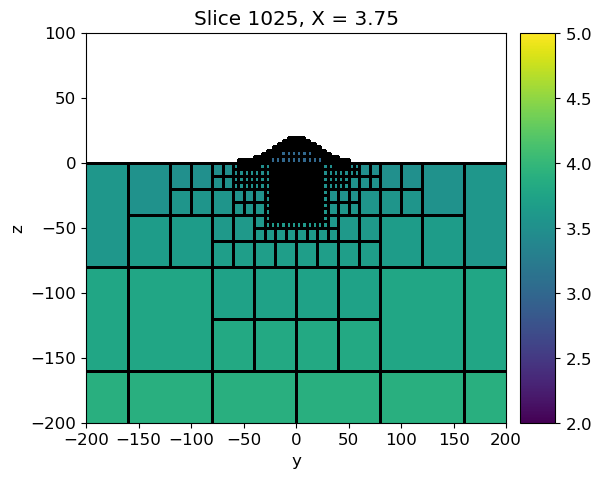

In [28]:
def plotmod(model,yref):
    # Plot Resistivity Model
    mpl.rcParams.update({"font.size": 12})
    fig = plt.figure(figsize=(7, 6))
    

    indy = int(np.argmin(abs(mesh.vectorCCy-yref)))
    ax1 = fig.add_axes([0.13, 0.1, 0.6, 0.65])
    mesh.plot_slice(
        plotting_map * model,
        normal="X",
        ax=ax1,
        ind=indy,
        grid=True,
        clim=(2, 5),
    )
    #ax1.set_title("Conductivity Model at Y = %f m" %yref)

    lim_len=200
    xlim = [-lim_len, lim_len]
    ylim = [-lim_len, lim_len/2]
    zlim = [-lim_len, lim_len]
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)

    ax2 = fig.add_axes([0.75, 0.1, 0.05, 0.65])
    norm = mpl.colors.Normalize(
        vmin=2, vmax=5
    )
    cbar = mpl.colorbar.ColorbarBase(
        ax2,norm=norm, orientation="vertical", format="$%.1f$"
    )
    #cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)
    


def getcoord2m(R,IC,coordr):
    #np.random.seed(IC)
    theta=45.0/180.0*np.pi
    fai=60/180.0*np.pi
    
    x_tar=R*cos(fai)*cos(theta)+coordr[0]
    y_tar=R*cos(fai)*sin(theta)+coordr[1]
    z_tar=R*sin(fai)+coordr[2]
    
    
    return [theta,fai],[x_tar,y_tar,z_tar]

def create_model(depth_tunnel,IC,ab_jud=True):
    z0=-200
    zmax=0
    #np.random.seed(IC)
    r0=np.random.uniform(log10(500),log10(5000))
    #print(r0)

    sig_air = 1e8
    sig_half = 1.0e3
    
    # Define model. Models in SimPEG are vector arrays
    model = log10(sig_half) * np.ones(ind_active.sum())
    mesh1=mesh.gridCC[ind_active]
    
    def get_meshres(z):
        if(z<-200):
            val=log10(5000+pow(10,r0))
        else:
            r_last1=log10(pow(10,r0)+1500)
            #r_last=np.max([r_last,r_last1])
            val=log10((zmax-z)/(zmax-z0)*5000+pow(10,r0))
            #print(r0,r_last,val)
        return val

    for i in range(len(mesh1)):
        x=mesh1[i][0]
        z=mesh1[i][2]
        if(z<=0):
            val=get_meshres(z)
            model[i]=val
    
    #depth_tunnel=np.random.uniform(30,60)
    
    ind_air = ((mesh.gridCC[ind_active, 0] < 0.0)
    & (mesh.gridCC[ind_active, 0] > -30.0)
    & (mesh.gridCC[ind_active, 1] < 6.0)
    & (mesh.gridCC[ind_active, 1] > -6.0)
    & (mesh.gridCC[ind_active, 2] > -depth_tunnel)
    & (mesh.gridCC[ind_active, 2] < -depth_tunnel+10))
    
    model[ind_air] = log10(sig_air)
    coordr=[-1,0,-depth_tunnel+2]
    #R=np.random.uniform(11,35)
    R=15
    coord_tarb,coord_tar=getcoord2m(R,IC,coordr)
    print('coord_tar:',coord_tar)
    R_tar=6
    dis=mesh1-coord_tar
    index_tar=np.linalg.norm(dis,axis=1)<R_tar
    #ab_res=np.random.uniform(0,1)
    ab_res=0.2
    if(ab_jud==True):
        model[index_tar]=ab_res
    model[ind_air] = log10(sig_air)
    
    return coordr,coord_tarb,coord_tar,model


from scipy import interpolate
interp_func = interpolate.interp2d(topo[:,0], topo[:,1], topo[:,2], kind='linear')

def get_source_coord(IC,X_input):
    #np.random.seed(IC*2+1)
    X1=np.random.uniform(-25,30)
    Y1=np.random.uniform(-30,-10)
    #np.random.seed(IC*2+2)
    X2=np.random.uniform(-30,30)
    Y2=np.random.uniform(-10,10)
    #np.random.seed(IC*2+3)
    X3=np.random.uniform(-30,30)
    Y3=np.random.uniform(10,30)
    
    x_arr=[X_input,X_input,X_input]
    y_arr=[Y1,Y2,Y3]
    Z_arr=interp_func(x_arr,y_arr)
    #print(Z_arr)
    coord_source1=[X_input,Y1,Z_arr[0,0]]
    coord_source2=[X_input,Y2,Z_arr[1,1]]
    coord_source3=[X_input,Y3,Z_arr[2,2]]
    return np.array([coord_source1,coord_source2,coord_source3])
    

def get_spatail_rela(coordr,coords):
    x1=coords[0]-coordr[0]
    y1=coords[1]-coordr[1]
    z1=coords[2]-coordr[2]
    R=sqrt(x1**2+y1**2+z1**2)
    fai=asin(z1/R)
    theta=atan(y1/(x1+0.1))
    return np.array([R/10,theta,fai])

IC=100+12
depth_tunnel=20
coordr,coord_tarb,coord_tar,model=create_model(depth_tunnel,IC,True)

plotmod(model,5)

Text(0, 0.5, '$Y (m)$')

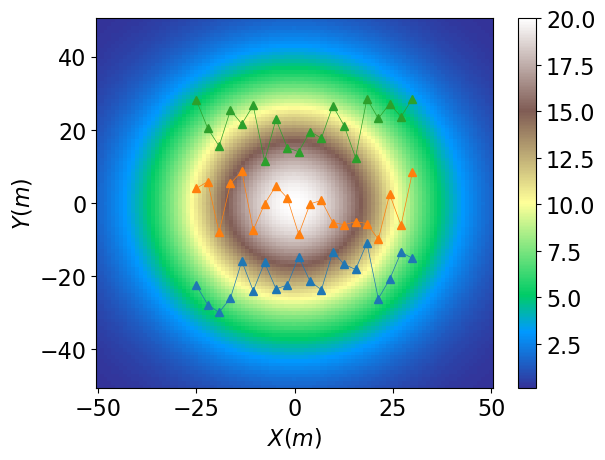

In [25]:
para=np.loadtxt('para.txt')

plt.rcParams.update({'font.size': 16})
X=np.linspace(-50,50,101)
Y=np.linspace(-50,50,101)
plt.pcolor(X,Y,topo[:,2].reshape([101,101]),cmap='terrain')
plt.plot(para[:,3],para[:,4],marker='^',linewidth=0.5)
plt.plot(para[:,5],para[:,6],marker='^',linewidth=0.5)
plt.plot(para[:,7],para[:,8],marker='^',linewidth=0.5)
plt.colorbar()
plt.xlabel(r'$X (m)$')
plt.ylabel(r'$Y (m)$')


coord_tar: [4.303300858899108, 5.303300858899108, -5.009618943233422]
[4.303300858899108, 5.303300858899108, -5.009618943233422]


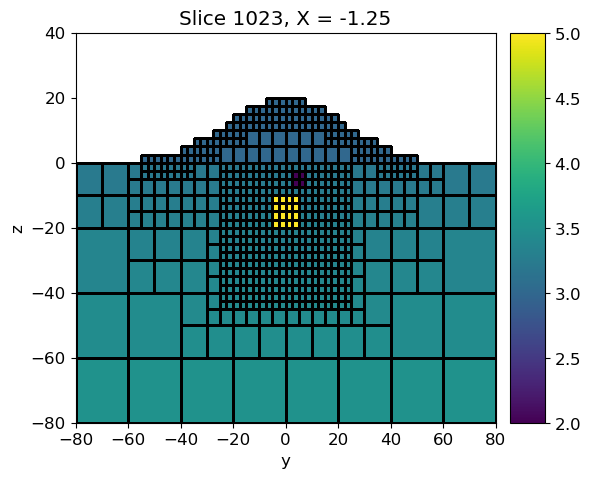

In [4]:

Ntf=24
time_channels = np.logspace(-5, -3, Ntf)
frequencies = np.logspace(1, 4, Ntf)




def simulation_FEM(coord_source,IC,model):
    highF=np.random.uniform(3.8,4.5)
    lowF=np.random.uniform(1,1.6)
    frequencies = np.logspace(lowF, highF, Ntf)
    
    srcList = []
    rec_lst=[]
    #for i in range(len(Xloc[-1])):
    #for i in range(len(Xloc[-1:])):
    #print(xloc)
    location_r = np.array([coordr])
    # rz_real = fdem.receivers.PointMagneticFluxDensity(location_r, 'z','real')
    # rz_imag = fdem.receivers.PointMagneticFluxDensity(location_r, 'z','imag')
    # rx_real = fdem.receivers.PointMagneticFluxDensity(location_r, 'x','real')
    # rx_imag= fdem.receivers.PointMagneticFluxDensity(location_r, 'x','imag')


    rx_real = fdem.receivers.PointMagneticFluxDensitySecondary(location_r, 'x','real')
    rx_imag= fdem.receivers.PointMagneticFluxDensitySecondary(location_r, 'x','imag')
    ry_real = fdem.receivers.PointMagneticFluxDensitySecondary(location_r, 'y','real')
    ry_imag= fdem.receivers.PointMagneticFluxDensitySecondary(location_r, 'y','imag')
    rz_real = fdem.receivers.PointMagneticFluxDensitySecondary(location_r, 'z','real')
    rz_imag = fdem.receivers.PointMagneticFluxDensitySecondary(location_r, 'z','imag')


    rec_lst.append(rx_real)
    rec_lst.append(rx_imag)
    rec_lst.append(ry_real)
    rec_lst.append(ry_imag)
    rec_lst.append(rz_real)
    rec_lst.append(rz_imag)


    location = np.array([coord_source[0]])
    for jj in range(len(frequencies)):
        src = fdem.sources.CircularLoop(rec_lst, frequencies[jj], orientation="x", location=location,moment=100)
        srcList.append(src)
        src = fdem.sources.CircularLoop(rec_lst, frequencies[jj], orientation="y", location=location,moment=100)
        srcList.append(src)
        src = fdem.sources.CircularLoop(rec_lst, frequencies[jj], orientation="z", location=location,moment=100)
        srcList.append(src)

    location = np.array([coord_source[1]])
    for jj in range(len(frequencies)):
        src = fdem.sources.CircularLoop(rec_lst, frequencies[jj], orientation="x", location=location,moment=100)
        srcList.append(src)
        src = fdem.sources.CircularLoop(rec_lst, frequencies[jj], orientation="y", location=location,moment=100)
        srcList.append(src)
        src = fdem.sources.CircularLoop(rec_lst, frequencies[jj], orientation="z", location=location,moment=100)
        srcList.append(src)

    location = np.array([coord_source[2]])
    for jj in range(len(frequencies)):
        src = fdem.sources.CircularLoop(rec_lst, frequencies[jj], orientation="x", location=location,moment=100)
        srcList.append(src)
        src = fdem.sources.CircularLoop(rec_lst, frequencies[jj], orientation="y", location=location,moment=100)
        srcList.append(src)
        src = fdem.sources.CircularLoop(rec_lst, frequencies[jj], orientation="z", location=location,moment=100)
        srcList.append(src)
        
    survey = fdem.Survey(srcList)
    simulation = fdem.Simulation3DMagneticFluxDensity(mesh,survey=survey, solver=Solver, verbose=False,  sigmaMap=model_map)
    #simulation = TDEM.Simulation3DMagneticFluxDensity(mesh3d,survey=survey, solver=Solver, verbose=False,  sigmaMap=maps.IdentityMap(mesh3d))
    dpred = simulation.dpred(1.0/np.power(10,model))
    return frequencies,dpred


def simulation_TEM(coord_source,IC,model):
    
    earlyT=np.random.uniform(-4.6,-5.2)
    lateT=np.random.uniform(-3.4,-2.7)
    time_channels = np.logspace(earlyT, lateT, Ntf)
    
    # assemble the sources and receivers
    Angle=np.arange(-90,100,10)
    # Frequencies being predicted (10 Hz to 10000 Hz)
    srcList = []

    rec_lst=[]
    location_r = np.array([coordr])
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(location_r, time_channels, 'x')
    ry = tdem.receivers.PointMagneticFluxTimeDerivative(location_r, time_channels, 'y')
    rz = tdem.receivers.PointMagneticFluxTimeDerivative(location_r, time_channels, 'z')

    rec_lst.append(rx)
    rec_lst.append(ry)
    rec_lst.append(rz) 


    location = np.array([coord_source[0]])
    src = tdem.Src.CircularLoop(rec_lst, orientation='x', location=location,moment=100)
    srcList.append(src)
    src = tdem.Src.CircularLoop(rec_lst, orientation='y', location=location,moment=100)
    srcList.append(src)
    src = tdem.Src.CircularLoop(rec_lst, orientation='z', location=location,moment=100)
    srcList.append(src)
    
    location = np.array([coord_source[1]])
    src = tdem.Src.CircularLoop(rec_lst, orientation='x', location=location,moment=100)
    srcList.append(src)
    src = tdem.Src.CircularLoop(rec_lst, orientation='y', location=location,moment=100)
    srcList.append(src)
    src = tdem.Src.CircularLoop(rec_lst, orientation='z', location=location,moment=100)
    srcList.append(src)
    
    location = np.array([coord_source[2]])
    src = tdem.Src.CircularLoop(rec_lst, orientation='x', location=location,moment=100)
    srcList.append(src)
    src = tdem.Src.CircularLoop(rec_lst, orientation='y', location=location,moment=100)
    srcList.append(src)
    src = tdem.Src.CircularLoop(rec_lst, orientation='z', location=location,moment=100)
    srcList.append(src)
    #print(time_channels)
    timesteps = [(1e-06, 10), (1e-05, 10), (0.0001, 20)]
    survey = tdem.Survey(srcList)
    simulation = tdem.Simulation3DMagneticFluxDensity(mesh,survey=survey, solver=Solver, verbose=False,  sigmaMap=model_map)
    #simulation = TDEM.Simulation3DMagneticFluxDensity(mesh3d,survey=survey, solver=Solver, verbose=False,  sigmaMap=maps.IdentityMap(mesh3d))
    simulation.time_steps =  timesteps
    dpred = simulation.dpred(1.0/np.power(10,model))
    return time_channels,dpred




IC=122+200   #122
mesh,ind_active,model_map,plotting_map=create_mesh()

coordr,coord_tarb,coord_tar,model=create_model(depth_tunnel,IC,True)

plotmod(model,0)

print(coord_tar)

In [5]:
def trans_label(coord_tarb,coord_tar,coord_source):
    mu = np.array(coord_tarb)*180.0/np.pi  # 均值
    sigma = np.array([[2.4, 0.5], [0.5, 1.4]]) *12 # 协方差矩阵
    # 生成二维网格
    x1=np.linspace(atan(0.5)-np.pi, np.pi-atan(0.5), 32)*180.0/np.pi
    y1=np.linspace(-85/180.0*np.pi, 85/180.0*np.pi, 24)*180.0/np.pi
    x, y = np.meshgrid(x1,y1)
    f=1.0/(2*np.pi*sigma[0][0]*sigma[1][1])*\
        np.exp(-0.5*((x-mu[0])*(x-mu[0])/sigma[0][0]/sigma[0][0]+(y-mu[1])*(y-mu[1])/sigma[1][1]/sigma[1][1]))
    f=(f-np.min(f))/(np.max(f)-np.min(f))+0.01
    
    
    #coord_source[0][0]=-5
    sigma = np.array([[2.4, 0.5], [0.5, 1.4]])*2.5
    x2=np.linspace(-30,30,32)
    y2=np.linspace(coord_source[0][0]-10,coord_source[0][0]+10,24)
    x2, y2 = np.meshgrid(x2,y2)
    mu0=coord_tar[1]
    mu1=coord_tar[0]
    f2=1.0/(2*np.pi*sigma[0][0]*sigma[1][1])*\
        np.exp(-0.5*((x2-mu0)*(x2-mu0)/sigma[0][0]/sigma[0][0]+(y2-mu1)*(y2-mu1)/sigma[1][1]/sigma[1][1]))
    #f2=(f2-np.min(f2))/(np.max(f2)-np.min(f2))
    maxf2=1.0/(2*np.pi*sigma[0][0]*sigma[1][1])
    f2=(f2/maxf2)+0.01
    #print('max of F2=',1.0/(2*np.pi*sigma[0][0]*sigma[1][1]))
    return x, y,f,x2, y2,f2

In [6]:
def scale_input(layer1):
    layer_=np.copy(layer1)
    scalev=[]
    for i in range(layer_.shape[1]):
        scale_val=max(layer_[:,i])
        highest_bit =int(log10(abs(scale_val)))
        scale_val=10 ** highest_bit
        scalev.append(log10(scale_val))
        layer_[:,i]=layer_[:,i]/scale_val
    return layer_,np.array(scalev)

def Input_cube(dpred_TEM,dpred_FEM,coordr,coord_source,time_channels,frequencies):
    dataobs_tem=dpred_TEM.reshape(3,3,3,len(time_channels))  #source,source_ori,recei_ori, time
    dataobs_fem=dpred_FEM.reshape(3,len(frequencies),3,6) #source,freq,source_ori,recei_ori 
    input_data=[]
    for i in range(3):
        RC_coord=get_spatail_rela(coordr,coord_source[i])   #different source_station
        block1_tem=np.transpose(dataobs_tem[i,0,:,:]/np.std(dataobs_tem[i,0,:,:])) #different source_ori
        block1_fem=dataobs_fem[i,:,0,:]/np.std(dataobs_fem[i,:,0,:])
        block2_tem=np.transpose(dataobs_tem[i,1,:,:]/np.std(dataobs_tem[i,1,:,:]))
        block2_fem=dataobs_fem[i,:,1,:]/np.std(dataobs_fem[i,:,1,:])
        block3_tem=np.transpose(dataobs_tem[i,2,:,:]/np.std(dataobs_tem[i,2,:,:]))
        block3_fem=dataobs_fem[i,:,2,:]/np.std(dataobs_fem[i,:,2,:])


        #print(layer1_tem.shape,layer1_fem.shape)
        layer1=np.concatenate((block1_tem, block1_fem,block2_tem,block2_fem,block3_tem,block3_fem), axis=1) #combine different source_ori
        #layer1,scalev=scale_input(layer1)
        layer2=-np.log10(np.abs(layer1))
        
        Np=len(frequencies)
        info1=np.ones(Np)*RC_coord[0]
        info2=np.ones(Np)*RC_coord[1]
        info3=np.ones(Np)*RC_coord[2]
#         info1[:18]=scalev[:18]
#         info2[:9]=scalev[18:]
#         info2[9:12]=RC_coord
        #info1.reshape(Np,1)
        #info2.reshape(Np,1)
        #print(info1.shape,layer1.shape)
        layer1=np.c_[layer1,info1,info2,info3,np.log10(time_channels),np.log10(frequencies)] #add scale and time fre information
        layer2=np.c_[layer2,np.zeros([Np,5])]
        #print(layer1.shape,layer2.shape,np.zeros([Np,2]).shape)
        input_data.append(layer1)
        input_data.append(layer2)
        #layer1=np.concatenate((layer1,info1),axis=1)
    return np.array(input_data)


#         scalev_=np.zeros(len(frequencies))
#         info=np.zeros(len(frequencies))
#         scalev_[:len(scalev)]=scalev
#         info[:3]=RC_coord
#         info[3+j]=1
#         print(scalev_,info)
#         #print(layer1.shape,scalev)
#         print(RC_coord)


In [72]:
X_input=np.linspace(-20,30,20)
X_input

array([-20.        , -17.36842105, -14.73684211, -12.10526316,
        -9.47368421,  -6.84210526,  -4.21052632,  -1.57894737,
         1.05263158,   3.68421053,   6.31578947,   8.94736842,
        11.57894737,  14.21052632,  16.84210526,  19.47368421,
        22.10526316,  24.73684211,  27.36842105,  30.        ])

In [13]:
time_start=time.time()
print(time.localtime(time_start))
#500~600 no abnormality
#for i in range(7500,10000):
X_input=np.linspace(-25,30,20)

f=open('para.txt','w')
f.write('depth_tunnel,theta,fai,source1_x,source1_y,source2_x,source2_y,source3_x,source3_y\n')

for i in range(20):
    print(i)
    IC=122+200    #122
    np.random.seed()
    
    mesh,ind_active,model_map,plotting_map=create_mesh()
    judnor=True
    coordr,coord_tarb,coord_tar,model=create_model(depth_tunnel,IC,judnor)
    coord_source= get_source_coord(IC,X_input[i])
    
    
    #coord_source[:,0]=coord_tar[0]+np.random.uniform(-5,5)
    print(coord_source)
    print(depth_tunnel)
    #plotmod(model,11)
    f.write('%f %f %f %f %f %f %f %f %f\n' %(depth_tunnel,coord_tarb[0],coord_tarb[1],coord_source[0][0],coord_source[0][1],
                                   coord_source[1][0],coord_source[1][1],coord_source[2][0],coord_source[2][1]))
    time_channels,dpred_FEM=simulation_FEM(coord_source,IC,model)
    frequencies,dpred_TEM=simulation_TEM(coord_source,IC,model)
    
    input_data=Input_cube(dpred_TEM,dpred_FEM,coordr,coord_source,time_channels,frequencies)
    thetax, faiy, label_pdf,xt, yt, labels=trans_label(coord_tarb,coord_tar,coord_source)
    if(judnor==False):
        label_pdf=np.zeros([32,24])
        labels=np.zeros([32,24])
    print(coord_tar)
    label_final=np.array([label_pdf,labels])
    np.save('data/Inpt_%d'%i, input_data)
    np.save('data/label_pdf_%d'%i, label_final)
    
f.close()

time_end=time.time()
print(time.localtime(time_end))



time.struct_time(tm_year=2025, tm_mon=1, tm_mday=26, tm_hour=12, tm_min=31, tm_sec=14, tm_wday=6, tm_yday=26, tm_isdst=0)
0
coord_tar: [4.303300858899108, 5.303300858899108, -5.009618943233422]
[[-25.         -22.51046549   6.44960795]
 [-25.           3.97701022  10.53719568]
 [-25.          28.08063053   4.86591539]]
20
1


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10180\231776787.py:123: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  Z_arr=interp_func(x_arr,y_arr)


coord_tar: [4.303300858899108, 5.303300858899108, -5.009618943233422]
[[-22.10526316 -27.7914701    5.66761764]
 [-22.10526316   5.81934166  11.85913479]
 [-22.10526316  20.38168453   8.09817162]]
20
2
coord_tar: [4.303300858899108, 5.303300858899108, -5.009618943233422]
[[-19.21052632 -29.92421286   5.64829942]
 [-19.21052632  -8.031189    12.96510125]
 [-19.21052632  15.52650147  10.86639476]]
20
3
coord_tar: [4.303300858899108, 5.303300858899108, -5.009618943233422]
[[-16.31578947 -26.0060599    7.79242912]
 [-16.31578947   5.34263601  14.89098976]
 [-16.31578947  25.36038415   8.05503065]]
20
4
coord_tar: [4.303300858899108, 5.303300858899108, -5.009618943233422]
[[-13.42105263 -15.89592957  12.97320343]
 [-13.42105263   8.59845036  15.50830758]
 [-13.42105263  21.58677597  10.48074524]]
20
5
coord_tar: [4.303300858899108, 5.303300858899108, -5.009618943233422]
[[-10.52631579 -23.99811215  10.06259776]
 [-10.52631579  -7.41953666  16.94916467]
 [-10.52631579  26.64218006   8.802315

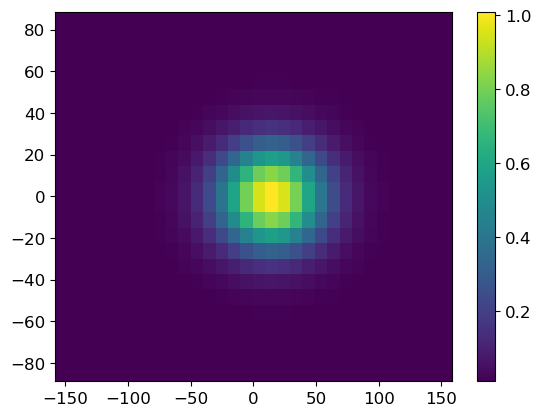

In [44]:
plt.pcolor(thetax, faiy,label_pdf)
plt.colorbar()

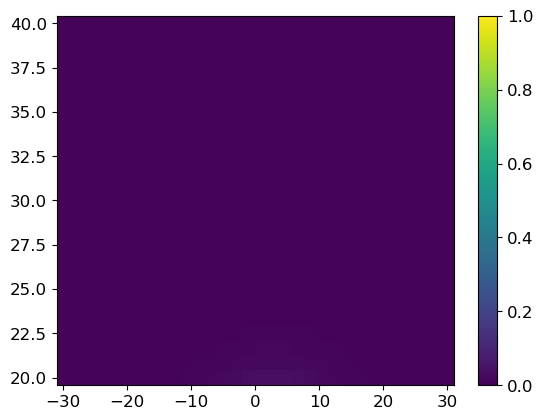

In [45]:
plt.pcolor(xt, yt,labels,clim=[0,1])
plt.colorbar()

In [102]:
np.random.seed(3)
x=np.random.uniform(5,10)
np.random.seed(3)
x1=np.random.uniform(15,20)
print(x,x1)

7.753989512872877 17.753989512872877


In [93]:
np.random.uniform(15,20)

17.554138025988316

In [89]:
np.random.seed(3)
np.random.uniform(25,30)

27.753989512872877